In [1]:
#Importing libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime

In [2]:
#Reading data
GME = pd.read_csv("GME.csv")

In [3]:
GME.head()

Date  Open  High   Low  Close  Adj Close   Volume
0  2020-01-21  4.75  4.75  4.55   4.59       4.59  3532100
1  2020-01-22  4.55  4.64  4.46   4.56       4.56  2627500
2  2020-01-23  4.55  4.64  4.46   4.62       4.62  1880200
3  2020-01-24  4.64  4.64  4.25   4.32       4.32  4163600
4  2020-01-27  4.20  4.35  4.16   4.28       4.28  2122500

*Note:* we only need the Date and Close columns

In [4]:
GME = GME[['Date', 'Close']]

In [5]:
GME.head()

Date  Close
0  2020-01-21   4.59
1  2020-01-22   4.56
2  2020-01-23   4.62
3  2020-01-24   4.32
4  2020-01-27   4.28

In [8]:
GME.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 257 entries, 0 to 256
Data columns (total 2 columns):
Date     257 non-null object
Close    257 non-null float64
dtypes: float64(1), object(1)
memory usage: 4.1+ KB


In [10]:
#Converting date column into datetime 
GME.Time = pd.to_datetime(GME.Date, format = '%Y/%m/%d')

## Plot of the GME stock price dataset

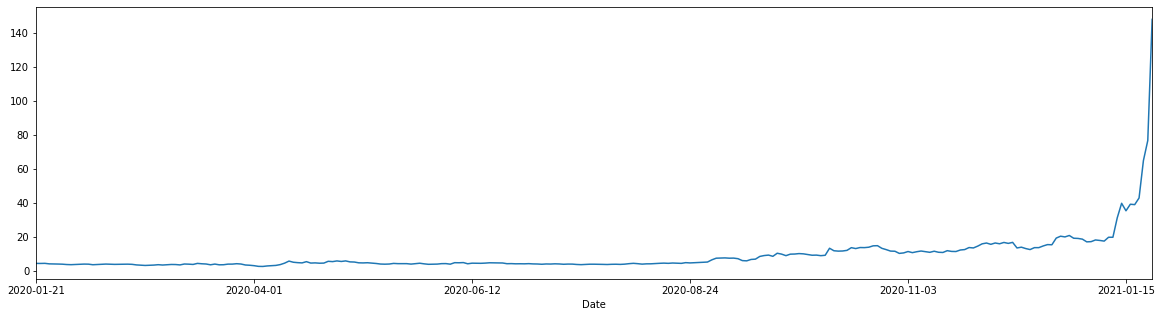

In [14]:
plot_GME = GME.set_index('Date')
plot_GME['Close'].plot(figsize=(20,5));

## Some Preprocessing

In [19]:
new_GME = GME.copy()

In [20]:
new_GME.tail()

Date       Close
252  2021-01-20   39.119999
253  2021-01-21   43.029999
254  2021-01-22   65.010002
255  2021-01-25   76.790001
256  2021-01-26  147.979996

In [25]:
print(new_GME.isnull().sum())

Close    0
dtype: int64


In [22]:
new_GME = new_GME.drop('Date', axis=1)
new_GME = new_GME.reset_index(drop=True)

In [23]:
new_GME.head()

Close
0   4.59
1   4.56
2   4.62
3   4.32
4   4.28

In [26]:
T = new_GME.values
T = T.astype('float32')

In [27]:
T = T[~np.isnan(T)]
T = np.reshape(T, (-1, 1))

## Min-max Scaling

In [28]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0, 1))
T = scaler.fit_transform(T)

## Test/Train split

In [29]:
train_size = int(len(T)*0.8)
test_size = int(len(T)-train_size)
train = T[0:train_size, :]
test = T[train_size: , :]

In [30]:
#Method for creating features for the time series data
def create_features(data, window_size):
    X, Y = [], []
    for i in range(len(data) - window_size - 1):
        window = data[i:(i + window_size), 0]
        X.append(window)
        Y.append(data[i + window_size, 0])
    return np.array(X), np.array(Y)

In [32]:
#Assuming 5 trading days per week
window_size = 20
X_train, Y_train = create_features(train, window_size)

X_test, Y_test = create_features(test, window_size)

#Reshaping to the format of [samples, time steps, features] (the format that lstm needs)

X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

In [33]:
#To check for a data leak
def isLeak(T_shape, train_shape, test_shape):
    return not(T_shape[0] == (train_shape[0] + test_shape[0]))

print(isLeak(T.shape, train.shape, test.shape))

False


## Building the LSTM RNN Model
Below, we build a LSTM model that consists of one LSTM layer with a density of 50 neurons and a RELU activation function, as well as a Dropout regularization layer. We add a model checkpoint that is looking to minimize the validation set's loss. We save each model that consists of a lower validation loss compared to any model that came before it.

In [36]:
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.callbacks import ModelCheckpoint

ModuleNotFoundError: No module named 'tensorflow'

In [35]:
#Setting seed
tf.random.set_seed(11)
np.random.seed(11)

NameError: name 'tf' is not defined

In [37]:
#Building model
model = Sequential()

model.add(LSTM(units=50, activation='relu', input_shape=(X_train.shape[1], window_size)))
model.add(Dropout(0.2))

model.add(Dense(1, activation='linear'))
model.compile(loss='mean_squared_error', optimizer='adam')

NameError: name 'Sequential' is not defined

In [39]:
import os 
os.system("mkdir GME1")

0

In [40]:
filepath = './model_epoch_{epoch:02d}.hdf5'

checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath = filepath,
                                               monitor='val_loss',
                                               verbose=1,
                                               save_best_only=True,
                                               mode='min')
history = model.fit(X_train, Y_train, epochs=3000, batch_size=80, validation_data=(X_test, Y_test),
                   callbacks=[checkpoint], verbose=1, shuffle=False)

model.summary()

NameError: name 'tf' is not defined

## Why we chose the model at epoch 89

The model at epoch 89 had the most similar training and validation losses, which implies that the model is not doing a lot of over or under fitting. As such, we load that model.

In [42]:
from keras.models import load_model
best_model = load_model('./model_epoch_558.hdf5')

# Predicting and inverse transforming the predictions

train_predict = best_model.predict(X_train)

Y_hat_train = scaler.inverse_transform(train_predict)

test_predict = best_model.predict(X_test)

Y_hat_test = scaler.inverse_transform(test_predict)

ModuleNotFoundError: No module named 'keras'

In [43]:
# Inverse transforming the actual values, to return them to their original values
Y_test = scaler.inverse_transform([Y_test])
Y_train = scaler.inverse_transform([Y_train])

In [44]:
Y_hat_train = np.reshape(Y_hat_train, newshape = 184)
Y_hat_test = np.reshape(Y_hat_test, newshape = 31)

Y_train = np.reshape(Y_train, newshape = 184)
Y_test = np.reshape(Y_test, newshape = 31)

NameError: name 'Y_hat_train' is not defined

## Evaluating Model Performance¶

### Computing the RMSE for the training and testing sets

In [45]:
from sklearn.metrics import mean_squared_error

train_RMSE = np.sqrt(mean_squared_error(Y_train, Y_hat_train))

test_RMSE = np.sqrt(mean_squared_error(Y_test, Y_hat_test))

print('Train RMSE is: ')
print(train_RMSE, '\n')
print('Test RMSE is: ')
print(test_RMSE)

NameError: name 'Y_hat_train' is not defined

### Visualizing the actual vs. predicted stock prices

In [46]:
Y = np.append(Y_train, Y_test)
Y_hat = np.append(Y_hat_train, Y_hat_test)

NameError: name 'Y_hat_train' is not defined

In [47]:
result_df = pd.DataFrame()

result_df['Actual_Y'] = Y
result_df['Predicted_Y'] = Y_hat


result_df.head()

NameError: name 'Y_hat' is not defined

KeyError: 'Predicted_Y'

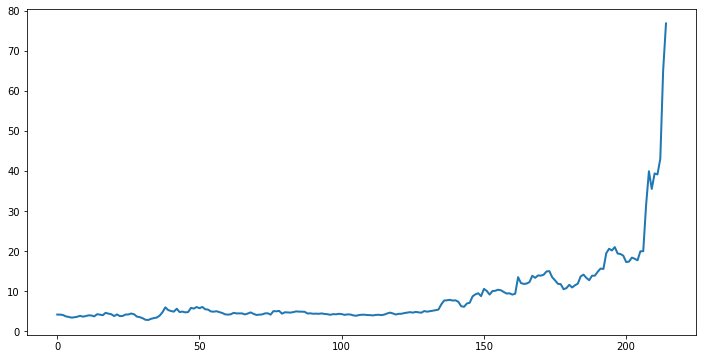

In [48]:
plt.figure(figsize = (12,6))
plt.plot(result_df["Actual_Y"],linewidth=2.0,label = "Actual")
plt.plot(result_df["Predicted_Y"],linewidth=2.0, label = "Predicted")
plt.rcParams.update({'font.size': 13})
plt.legend(loc="upper left", bbox_to_anchor=(0.03,1))
plt.show()